In [2]:
import matplotlib.pyplot as plt
import requests
import asyncio
import nest_asyncio

nest_asyncio.apply()  # Enable nested asyncio support


In [3]:
docker_url = "http://localhost:5000"

## 10k requests on 3 servers

In [13]:
num_servers = 3
body = {"n": num_servers, "hostnames": ["s1", "s2"]}

res = requests.post(f"{docker_url}/add", json=body)
print(res.json())

{'message': {'N': 3, 'replicas': ['s1', 's2', 'pub_server_4']}, 'status': 'successful'}


In [5]:
num_requests = 10
server_ids = []


async def make_request():
    res = requests.get(f"{docker_url}/home")
    if res.status_code == 200:
        server_ids.append(int(res.json()["message"][19:]))
    else:
        print(res.json())


async def make_all_requests():
    tasks = [make_request() for _ in range(num_requests)]
    await asyncio.gather(*tasks)


asyncio.get_event_loop().run_until_complete(make_all_requests())

{'message': '<Error> home endpoint does not exist in server replicas', 'status': 'unsuccessful'}
{'message': '<Error> home endpoint does not exist in server replicas', 'status': 'unsuccessful'}
{'message': '<Error> home endpoint does not exist in server replicas', 'status': 'unsuccessful'}
{'message': '<Error> home endpoint does not exist in server replicas', 'status': 'unsuccessful'}
{'message': '<Error> home endpoint does not exist in server replicas', 'status': 'unsuccessful'}
{'message': '<Error> home endpoint does not exist in server replicas', 'status': 'unsuccessful'}


[8420.    0.  457.] [1.         1.33333333 1.66666667 2.        ] <BarContainer object of 3 artists>


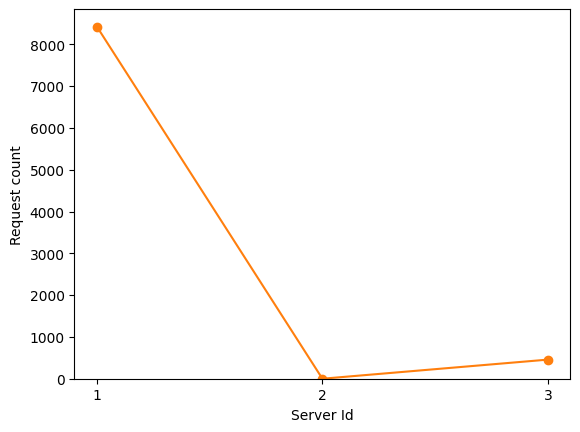

In [11]:
n, x, _ = plt.hist(server_ids, bins=3, alpha=0)
plt.plot([i for i in range(1, num_servers + 1)], n, marker="o", linestyle="-")
plt.ylabel("Request count")
plt.xlabel("Server Id")
plt.xticks([i for i in range(1, num_servers + 1)])
plt.show()

In [6]:
body = {"n": 3, "hostnames": []}

res = requests.delete(f"{docker_url}/rm", json=body)
print(res.json())

{'message': {'N': 1, 'replicas': ['s1']}, 'status': 'successful'}
{'message': {'N': 2, 'replicas': ['s1', 'pub_server_8']}, 'status': 'successful'}
[ 821. 1121.] [7.  7.5 8. ] <BarContainer object of 2 artists>


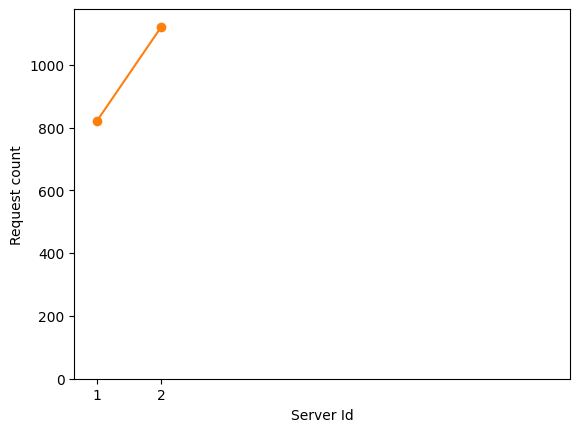

{'message': {'N': 3, 'replicas': ['s1', 'pub_server_8', 'pub_server_9']}, 'status': 'successful'}


KeyboardInterrupt: 

: 

In [16]:
body = {"n": 1, "hostnames": ["s1"]}
res = requests.post(f"{docker_url}/add", json=body)
print(res.json())

all_server_ids = []

for num_servers in range(2, 7):
    body = {"n": 1, "hostnames": []}
    res = requests.post(f"{docker_url}/add", json=body)
    print(res.json())
    server_ids = []
    asyncio.get_event_loop().run_until_complete(make_all_requests())
    n, x, _ = plt.hist(server_ids, bins=num_servers, alpha=0)
    print(n, x, _)
    plt.plot([i for i in range(1, num_servers + 1)], n, marker="o", linestyle="-")
    plt.ylabel("Request count")
    plt.xlabel("Server Id")
    plt.xticks([i for i in range(1, num_servers + 1)])
    plt.show()

In [1]:
requests.get(f"{docker_url}/rep").json()

NameError: name 'requests' is not defined